## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Here we will Inclusive-Exclusive Principle with a note that we exclude twice the intersection
(df.group=='treatment').sum()+(df.landing_page=='new_page').sum()-2*(((df.group=='treatment') & (df.landing_page=='new_page')).sum())

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df.group=='treatment')&(df.landing_page=='new_page'))|((df.group=='control')&(df.landing_page=='old_page'))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2 = df2.drop(2893,axis=0)

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2.group=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2.group=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2.landing_page=='new_page').mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Explanation.** Observe that the probabilities of receiving new page or old page are the same but the probability of conversion in treatment group is less than the probability of conversion in the control group. This tells us that with the same number of individuals in treatment and control groups, then there are more people converted in the control group than in the treatment group. This is the evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer.**
<div align=center> $H_0: p_{old}\geq p_{new}$</div>
<div align=center> $H_1: p_{old} < p_{new}$</div>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
# Under the null p_new=p_old = conversion rate of the whole dataset
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = len(df2[df2.group=='treatment'])
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = len(df2[df2.group=='control'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice(range(2),p=(1-p_new,p_new),size = n_new )

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice(range(2),p=(1-p_old,p_old),size = n_old )

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean()-old_page_converted.mean()

0.0013265689163093064

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice(range(2),p=(1-p_new,p_new),size = n_new )
    old_page_converted = np.random.choice(range(2),p=(1-p_old,p_old),size = n_old )
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  12.,   95.,  468., 1612., 2850., 2743., 1606.,  503.,   97.,
          14.]),
 array([-4.66176153e-03, -3.73396976e-03, -2.80617800e-03, -1.87838624e-03,
        -9.50594479e-04, -2.28027172e-05,  9.04989044e-04,  1.83278081e-03,
         2.76057257e-03,  3.68836433e-03,  4.61615609e-03]),
 <a list of 10 Patch objects>)

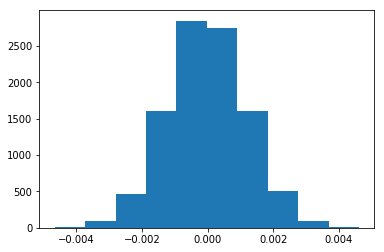

In [26]:
plt.hist(p_diffs)

The histogram looks like a bell curve centered at 0 so the `p_diffs` has normal distribution with mean 0. This is what we expected because under the Central limit theorem, with sample size 10000, we would expect `p_diffs` to have normal distribution. Also the mean should be 0 because `p_old-p_new=0` under the null.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
actual_obs_diff = df2[df2.group=='control']['converted'].mean()-df2[df2.group=='treatment']['converted'].mean()
(np.array(p_diffs)>actual_obs_diff).mean()

0.0935

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer.** The value compted in part **j** is called the `p-value` of the test. Since the `p-value = 0.093` is greater than `\alpha=5%` the level of significance so we don't have enough statistical evidence to reject the null hypothesis. That means we don't have enough evidence to say that there is a difference between the new and the old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
from statsmodels.stats.proportion import proportions_ztest

convert_old = df2[df2.group=='control']['converted'].sum()
convert_new = df2[df2.group=='treatment']['converted'].sum()
n_old = len(df2[df2.group=='control'])
n_new = len(df2[df2.group=='treatment'])

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
stat, pval = proportions_ztest( [convert_old,convert_new],[n_old,n_new],alternative='larger')
print([stat,pval])

[1.3109241984234394, 0.09494168724097551]


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer.** 
 - The `z-score` measures how many standard devation far from the population difference under the null, the observed data is. In this case, under the null, the difference of the conversion rates is 0. Then the difference in the observed data is 1.31 times standard deviation far from 0. 
 - The `p-value = 0.095` is the probability of observing a sample difference of conversion rates as extreme as the we have in the observed data. Since we choose the level of significance is $\alpha=0.05$ then $p-value>\alpha$ hence we don't have enough statistical evidence to reject the null hypothesis. In other words, we can't say the new page is better than the old page.
 - The values computed in part **j** and here are almost the same. Actually they are two difference methods to perform the A/B test.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer.** Note when you are constructing a **linear regression model** you are assuming that your dependent variable `y` is normally distributed. But when you have a binary dependent variable, this assumption is heavily violated. Thus, it doesn't makes sense to use linear regression when your dependent variable is binary. In this case, we will use **logistic regression model**.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
import statsmodels.api as sm
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
logit_mod = sm.Logit(df2.converted,df2[['intercept','ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:09:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer.** The `p=value` associated with **ab_page** is 0.19 which differ from the value 0.0949 we found in **Part II**. The reason is the hypothesis test here is the two-sided test, 

<div aligh=center> $H_0: p_{old}-p_{new} = 0$ </div>
<div aligh=center> $H_1: p_{old}-p_{new} \neq 0$ </div>

and the hypothesis test we used in **Part II** is one-sided test. The `p-value` in the two-sided test is double the `p-value` in the one-sided test. So that is the reason of the difference results we found.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer.** 
- In the previous computations, we see that with only variable **ab_page**, the variable seems not to be significance for the prediction. So a good idea is that we add some more factors into the model. 
- The disadvantages of adding additional terms is that (1) it makes the model more complicated and may lead to overfitting; (2) it could raise collinearity problem. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [34]:
### Create the necessary dummy variables
df_new[['UK','US']] = pd.get_dummies(df_new.country)[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [35]:
# fit the model again with new variables
logit_mod2 = sm.Logit(df_new.converted,df_new[['intercept','ab_page','UK','US']])
result2 = logit_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:09:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Answer**
With `p-values` are 0.074 and `0.130` corresponding to `UK` and `US`, we see that country does have impact on conversion but it is still not significance.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [36]:
# Add interaction between country and page
df_new['ab_page in UK'] = df_new['ab_page']*df_new['UK']
df_new['ab_page in US'] = df_new['ab_page']*df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,ab_page in UK,ab_page in US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [37]:
### Fit Your Linear Model And Obtain the Results
logit_mod3 = sm.Logit(df_new.converted,df_new[['intercept','ab_page','UK','US','ab_page in UK','ab_page in US']])
result3 = logit_mod3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 05 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:09:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page          -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK                0.0118      0.040      0.296      0.767      -0.066       0.090
US                0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page in UK     0.0783      0.057      1.378      0.168      -0.033       0.190
ab_page in US     0.0469      0.054      0.872      0.383      -0.059       0.152
=================================================================================
"""

**Answer** Even though, we added interaction between page and country, the impact of the existing varibles are still not significance.

<a id='conclusions'></a>
## Conclusions

In this part, to answer the question about whether the new page is better than the old page or not. We go through to techniques:

**1. A/B test:** the statistical result tells us that there is no statistical evidence to say the new page is better than to old page.

**2. Regression** the statiscal result of the logistic regression model tells us that `landing_page` is not significance for predicting conversion. That means the impact of change the old page by the new page is not clear on the conversion rate. Other words, there is still no statistical evidence to say the new page is better than to old page. We even add new factors to the model but we still don't find any other variables that have high impact on the conversion rate.

Beside the statistical results, we can also observe that the conversion rate of the control group is `12%` and the conversion rate of the treatment group is `11.8%` which is very closed so we would not expect that the new page better than the old page.

**Conclusion:** there is no evidence to say the new page is better than to old page.

### Resources

1. https://stattrek.com/hypothesis-test/proportion.aspx
2. https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html